In [1]:
import nltk
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from typing import Tuple
import numpy as np

class TfidfVectorizer:
    """
    A class to represent a TF-IDF vectorizer.
    """

    def __init__(self):
        pass


    def _split_sentences(self, text: str) -> None:
        """
        Split the text into sentences.

        Args:
            text (str): The input text to be split into sentences.
        
        Returns:
            list: A list of sentences.
        """

        # Cut text into sentences
        return sent_tokenize(text)


    def _preprocess_text(self, sentences_list: list) -> Tuple[list, set, dict, dict, int]:
        """
        Preprocess the text:
            - Convert to lowercase.
            - Remove punctuation.

        Returns:
            sentences (list): List of tokenized sentences.
            word_set (set): Set of unique words.
            word_count (dict): Dictionary with words as keys and their document frequency as values.
            word_dict (dict): Dictinary with words as keys and their indices as values.
            total_documents (int): Number of sentences.
        """

        sentences = []
        word_set = []
        
        for sent in sentences_list:
            words = [word.lower() for word in word_tokenize(sent) if word.isalpha()]
            sentences.append(words)
            for word in words:
                if word not in word_set:
                    word_set.append(word)

        word_set = set(word_set)

        total_documents = len(sentences)
        
        word_dict = {}
        word_dict = {word: i for i, word in enumerate(word_set)}


        word_count = {}
        for word in word_set:
            word_count[word] = 0
            for sent in sentences:
                if word in sent:
                    word_count[word] += 1
                    
        return sentences, word_set, word_count, word_dict, total_documents
    

    
    def _term_freq(self, words: list, word: str) -> float:
        """
        Calculate TF (Term Frequency) for the preprocessed text.

        Args:
            words (list): List of words in the sentence.s
            word (str): The word to calculate TF.

        Returns:
            float: the TF value.
        """

        N = len(words)
        occurance = len([token for token in words if token == word])

        return occurance / N
    
    
    def _inverse_doc_freq(self, word: str, word_count: dict, total_documents: int) -> float:
        """
        Calculate IDF (Inverse Document Frequency) for the given word.

        Args:
            word (str): The word to calculate IFD.
            word_count (dict): Dictionary with words as keys and their doc frequency as values.
            total_documents (int): Total number of sentences.

        Returns:
            float: The IDF value for the word.
        """
        word_occurrence = word_count.get(word) 

        idf = np.log(total_documents / word_occurrence)

        return idf
    

    def _tf_idf(self, sentence: list, word_set: set, word_count: dict, 
                     word_dict: dict, total_documents: int) -> np.ndarray:
        """
        Calculate the TF-IDF vector.

        Args:
            sentence (list): List of words in the sentence.
            word_set (set): Set of unique words.
            word_count (dict): Dictionary with words as keys and their document frequency as values.
            word_dict (dict): Dictionary with words as keys and their indices as values.
            total_documents (int): Total number of sentences.
        
        Returns:
            np.ndarray: The TF-IDF vector.
        """
        
        tf_idf_vec = np.zeros((len(word_set),))

        for word in sentence:
            tf = self._term_freq(sentence, word)
            idf = self._inverse_doc_freq(word, word_count, total_documents)
            
            value = tf * idf
            tf_idf_vec[word_dict[word]] = value 

        return tf_idf_vec
    

    def transform(self, text: str) -> np.ndarray:
        """
        Implement the TF-IDF vectorization process.

        Returns:
            np.array: The TF-IDF vector for the text.
        """

        #Split text into sentences
        sentences_list = self._split_sentences(text)

        # Preprocess text and calculate TF-IDF vectors
        vectors = []
        sentences, word_set, word_count, word_dict, total_documents = self._preprocess_text(sentences_list)

        for sentence in sentences:
            tf_idf_vec = self._tf_idf(sentence, word_set, word_count, word_dict, total_documents)
            vectors.append(tf_idf_vec)
        
        return np.array(vectors)

[nltk_data] Downloading package punkt_tab to C:\Users\Huynh
[nltk_data]     Thuan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


class FeatureVectorizer:
    """
    A class to vectorize text, arrays, dataframes to a feature vector.
    """

    def __init__(self):
        pass
    
        
    def _text_vectorizer(self, text: str) -> np.ndarray:
        """
        Vectorize text data into a feature vector.

        Returns:
            np.ndarray: An array representing the feature vector of the text data.
        """
        return TfidfVectorizer().transform(text)


    def _image_vectorizer(self, image_matrix: np.ndarray) -> np.ndarray:
        """
        Vectorize image data into a feature vector.
        
        Returns:
            np.ndarray: An array representing the feature vector of the image data.
        """

        # Check params
        if not isinstance(image_matrix, np.ndarray):
            raise TypeError("image_matrix must be a numpy array.")
        
        # if image_matrix.shape != (64, 64):
        #     raise ValueError("image_matrix must be of shape (64, 64).")

        plt.imshow(image_matrix, cmap='gray')
        plt.axis('off')
        plt.savefig("test_output.png")   # Lưu ảnh
        plt.show()

        # row, col = image_matrix.shape

        # flat_array = np.zeros((row * col,))

        # idx = 0

        # for i in range(row):
        #     for j in range(col):
        #         flat_array[idx] = image_matrix[i][j]
        #         idx += 1
            
        # return flat_array      # shape (row * col,)
    

    def _table_vectorizer(self, table_data: pd.DataFrame, length_threshold: int = 50) -> np.ndarray:
        """
        Normalize and vectorize table data into a feature vector.

        Returns:
            np.ndarray: An array representing the feature vector of the table data.
        """

        # Check params
        if not isinstance(table_data, pd.DataFrame):
            raise TypeError("table_data must be a pandas DataFrame.")
        
        # Normalize numeric columns
        for numeric_col in table_data.select_dtypes(include = ['number']).columns:
            mean = table_data[numeric_col].mean()
            std  = table_data[numeric_col].std()
            table_data[numeric_col] = (table_data[numeric_col] - mean) / std

        # Columns to drop (comment, long text, ...)
        cols_to_drop = []

        # Label Encoding for text columns
        for text_col in table_data.select_dtypes(include = ['object']).columns:
            if isinstance(table_data[text_col], pd.DataFrame):
                print(table_data)
            avg_length = table_data[text_col].fillna('').apply(lambda x: len(str(x))).mean()
            unique_values = list(table_data[text_col].unique())

            # Check:
            # 1. If the average length of the text is below the threshold
            # (Avoid comment columns, long text columns, ...)
            # 2. If the number of unique values is less than half of the total number of rows
            # (Avoid columns with too many unique values, like names, ...)
            if avg_length < length_threshold and len(unique_values) < len(table_data) / 2: 
                table_data[text_col] = table_data[text_col].\
                                       apply(lambda x: unique_values.index(x)).fillna(-1).astype('int')
            
            # If the average length is above the threshold or the number of unique values is too high, remove the column
            else:
                cols_to_drop.append(text_col)
        
        # Drop long text columns
        normalized_data = table_data.drop(columns = cols_to_drop)

        # Convert to numpy array
        normalized_data = normalized_data.to_numpy()

        return normalized_data
    def vectorize(self, data_info: dict) -> np.ndarray:
        print("AAA")
        """
        Vectorize the data based on its type.
        
        Returns:
            np.ndarray: An array representing the feature vector of the data.
        """

        # Check params
        if not isinstance(data_info, dict):
            raise TypeError("data_info must be a dict.")
        
        if not all(key in data_info for key in ['type', 'content', 'meta']):
            raise ValueError("data_info must contain 'type', 'content', and 'meta' keys.")

        # Check params
        if data_info['type'] not in ['mutiple', 'text', 'image', 'table']:
            raise ValueError("data_type must be one of 'text', 'image', 'table'.")
        
        data_type = data_info['type']
        content   = data_info['content']
        metadata  = data_info['meta']
        
        # Handle different data types
        if data_type == 'mutiple':
            vectors = []
            # if content['text'] is not None:
            #     vectors.append(self._text_vectorizer(content['text']))
            
            if content['images'] is not None:
                for image in content['images']:
                    vectors.append(self._image_vectorizer(image))
            
            # if content['tables'] is not None:
            #     for table in content['tables']:
            #         vectors.append(self._table_vectorizer(table))
            
            return vectors
        
        # Handle text data type
        elif data_type == 'text':
            return self._text_vectorizer(content)
        
        # Handle image data type
        elif data_type == 'image':
            return self._image_vectorizer(content)
        
        # Handle table data type
        else: return self._table_vectorizer(content)




CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

AAA


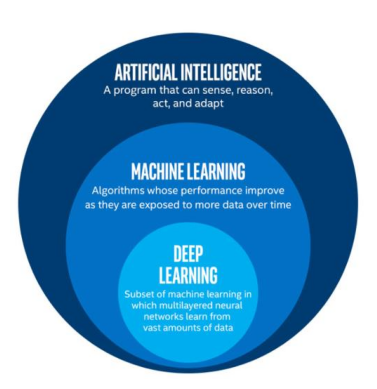

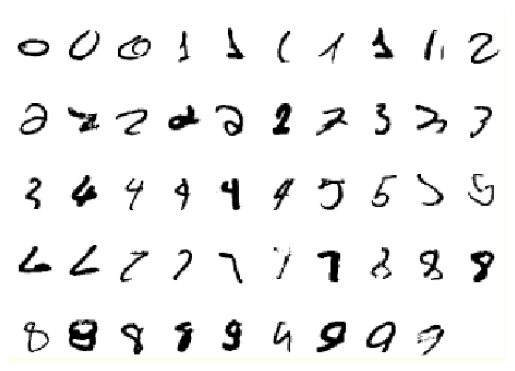

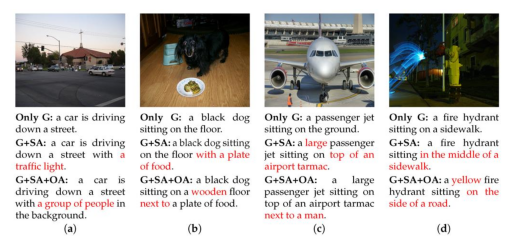

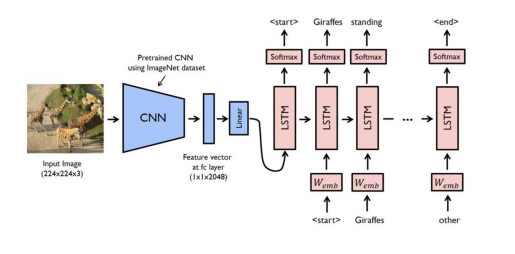

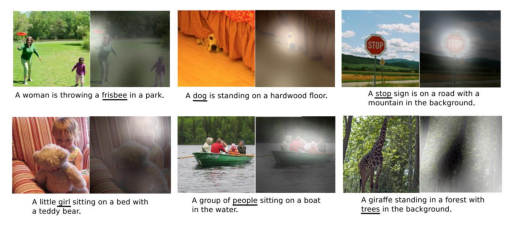

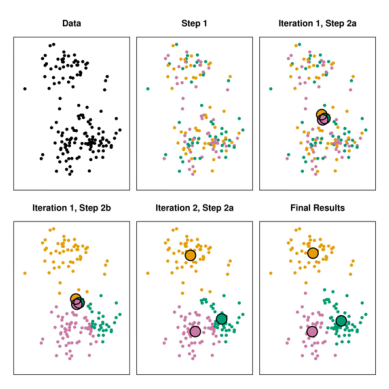

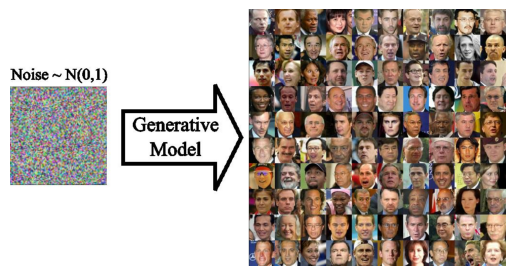

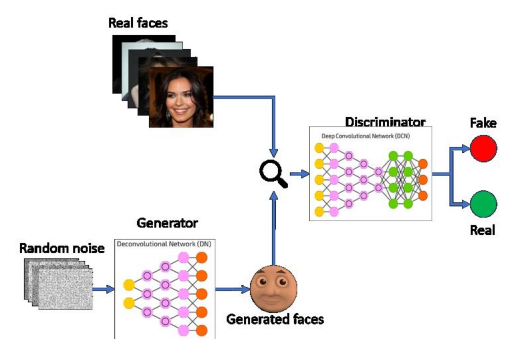

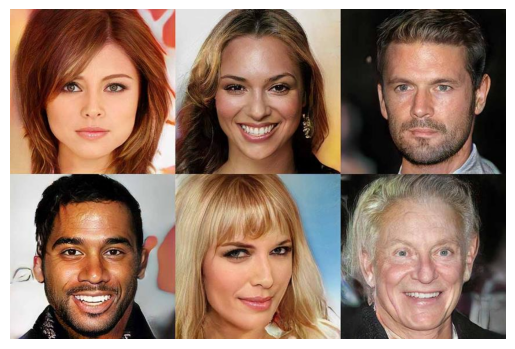

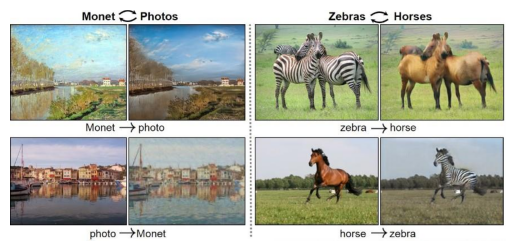

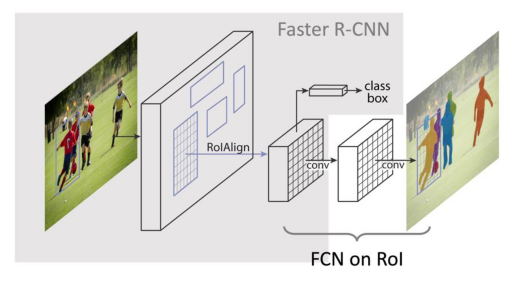

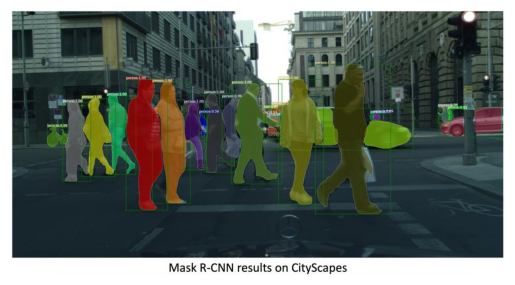

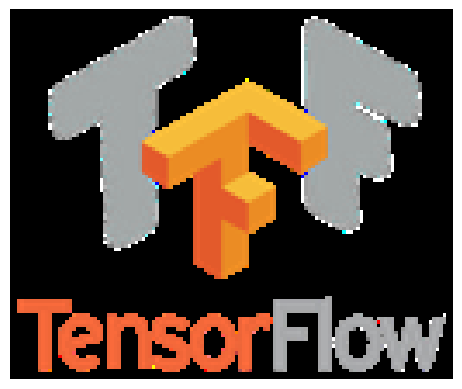

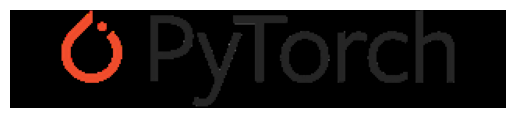

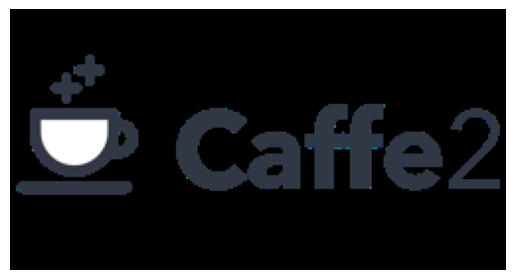

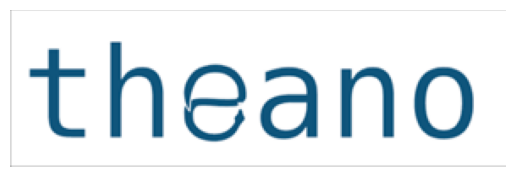

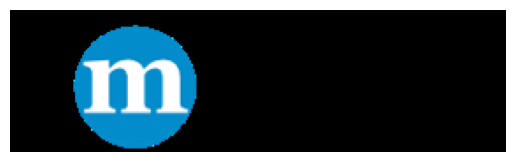

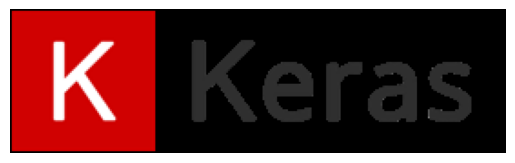

In [24]:
import os
import numpy as np
import pandas as pd
from src.Reader.reader_agent import DataExpander

# Path to the files
txt_path   = os.path.join("data_test_for_reader", "report.txt")
image_path = os.path.join("data_test_for_reader", "cat.jpg")
table_path = os.path.join("data_test_for_reader", "Network.csv")
pdf_path   = os.path.join("data_test_for_reader", "test_pdf.pdf")


def main():
    # 0. Call modules
    reader = DataExpander()
    vectorizer = FeatureVectorizer()


    # 1. Read files
    #text_data = dict(reader.expand(txt_path)[0])
    #image_data = dict(reader.expand(image_path)[0])
    #table_data = dict(reader.expand(table_path)[0])
    pdf_data = dict(reader.expand(pdf_path)[0])

    # 2. Vectorize data
    #text_vector = vectorizer.vectorize(text_data)
    #image_vector = vectorizer.vectorize(image_data)
    #table_vector = vectorizer.vectorize(table_data)
    pdf_vector = vectorizer.vectorize(pdf_data)

    # 3. Print results
    #print("text after vectorization: \n", text_vector)
    #print("image after vectorization:", image_vector)
    # print("table after vectorization: \n", table_vector)
    #print("pdf after vectorization: \n", pdf_vector)

if __name__ == "__main__":
    main()
